# Description

This notebook will be the opportunity to explore the Chinook database with the help of SQL and Pandas.

According to Luis Rocha, creator of the Chinook database :

    "The Chinook data model represents a digital media store, including tables for artists, albums, media tracks, invoices and customers.

    Media related data was created using real data from an iTunes Library. [...] Customer and employee information was manually created using fictitious names, addresses that can be located on Google maps, and other well formatted data (phone, fax, email, etc.). Sales information is auto generated using random data for a four year period."

For further informations : https://github.com/lerocha/chinook-database

Through several queries here are the questions that will be adressed :
- which artists are the most popular ?
- what is the most popular music genre for each country ? 
- who are the most spending customers for each country ?
- how do employees perform ?
- how sales are going for each country ?
- how high country average sales are per customer ?
- would it be better for Chinook to only propose the most popular song of an album instead of every track ?


# Set UP

In [1]:
import os, os.path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import sqlite3
import re

import warnings
warnings.filterwarnings("ignore")

from pandas.plotting import register_matplotlib_converters
import seaborn as sns
sns.set(
    font_scale=1.5,
    style="darkgrid",
    rc={'figure.figsize':(20,7)})

from IPython.display import Image
    
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)

pd.set_option('display.max_colwidth', 500)

pd.set_option('display.width', 300)
pd.set_option('display.precision',3)

# Useful functions

In [2]:
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = """
    SELECT *
    FROM sqlite_master
    WHERE type="table";
    """
    return run_query(q)

# The Chinook database 

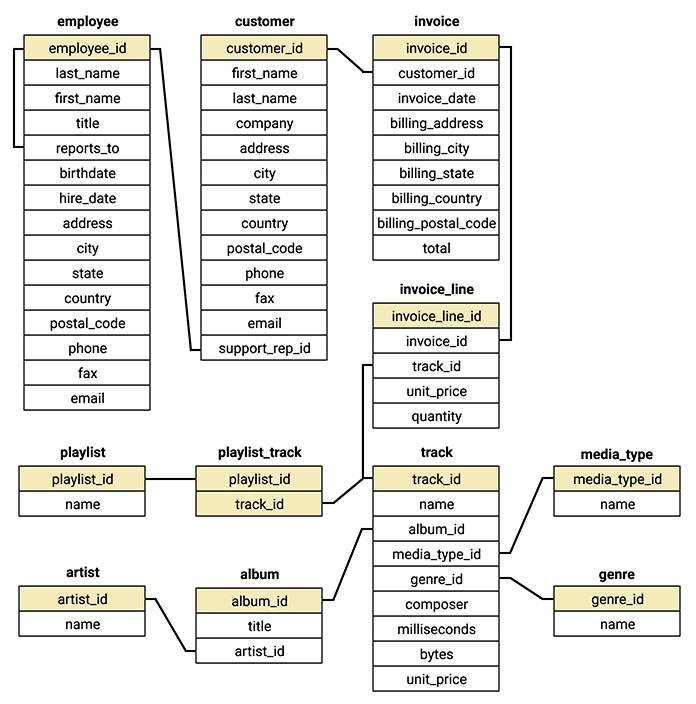

In [3]:
Image("./chinook-schema.png")

In [4]:
db = "./chinook.db"
conn = sqlite3.connect(db)
show_tables()

,type,name,tbl_name,rootpage,sql
0,table,album,album,2,"CREATE TABLE [album]\n(\n [album_id] INTEGER PRIMARY KEY NOT NULL,\n [title] NVARCHAR(160) NOT NULL,\n [artist_id] INTEGER NOT NULL,\n FOREIGN KEY ([artist_id]) REFERENCES [artist] ([artist_id]) \n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\n)"
1,table,artist,artist,3,"CREATE TABLE [artist]\n(\n [artist_id] INTEGER PRIMARY KEY NOT NULL,\n [name] NVARCHAR(120)\n)"
2,table,customer,customer,4,"CREATE TABLE [customer]\n(\n [customer_id] INTEGER PRIMARY KEY NOT NULL,\n [first_name] NVARCHAR(40) NOT NULL,\n [last_name] NVARCHAR(20) NOT NULL,\n [company] NVARCHAR(80),\n [address] NVARCHAR(70),\n [city] NVARCHAR(40),\n [state] NVARCHAR(40),\n [country] NVARCHAR(40),\n [postal_code] NVARCHAR(10),\n [phone] NVARCHAR(24),\n [fax] NVARCHAR(24),\n [email] NVARCHAR(60) NOT NULL,\n [support_rep_id] INTEGER,\n FOREIGN KEY ([support_rep_id]) REFERENC..."
3,table,employee,employee,5,"CREATE TABLE [employee]\n(\n [employee_id] INTEGER PRIMARY KEY NOT NULL,\n [last_name] NVARCHAR(20) NOT NULL,\n [first_name] NVARCHAR(20) NOT NULL,\n [title] NVARCHAR(30),\n [reports_to] INTEGER,\n [birthdate] DATETIME,\n [hire_date] DATETIME,\n [address] NVARCHAR(70),\n [city] NVARCHAR(40),\n [state] NVARCHAR(40),\n [country] NVARCHAR(40),\n [postal_code] NVARCHAR(10),\n [phone] NVARCHAR(24),\n [fax] NVARCHAR(24),\n [email] NVARCHAR(60),\n F..."
4,table,genre,genre,6,"CREATE TABLE [genre]\n(\n [genre_id] INTEGER PRIMARY KEY NOT NULL,\n [name] NVARCHAR(120)\n)"
5,table,invoice,invoice,7,"CREATE TABLE [invoice]\n(\n [invoice_id] INTEGER PRIMARY KEY NOT NULL,\n [customer_id] INTEGER NOT NULL,\n [invoice_date] DATETIME NOT NULL,\n [billing_address] NVARCHAR(70),\n [billing_city] NVARCHAR(40),\n [billing_state] NVARCHAR(40),\n [billing_country] NVARCHAR(40),\n [billing_postal_code] NVARCHAR(10),\n [total] NUMERIC(10,2) NOT NULL,\n FOREIGN KEY ([customer_id]) REFERENCES [customer] ([customer_id]) \n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\n)"
6,table,invoice_line,invoice_line,8,"CREATE TABLE [invoice_line]\n(\n [invoice_line_id] INTEGER PRIMARY KEY NOT NULL,\n [invoice_id] INTEGER NOT NULL,\n [track_id] INTEGER NOT NULL,\n [unit_price] NUMERIC(10,2) NOT NULL,\n [quantity] INTEGER NOT NULL,\n FOREIGN KEY ([invoice_id]) REFERENCES [invoice] ([invoice_id]) \n\t\tON DELETE NO ACTION ON UPDATE NO ACTION,\n FOREIGN KEY ([track_id]) REFERENCES [track] ([track_id]) \n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\n)"
7,table,media_type,media_type,9,"CREATE TABLE [media_type]\n(\n [media_type_id] INTEGER PRIMARY KEY NOT NULL,\n [name] NVARCHAR(120)\n)"
8,table,playlist,playlist,10,"CREATE TABLE [playlist]\n(\n [playlist_id] INTEGER PRIMARY KEY NOT NULL,\n [name] NVARCHAR(120)\n)"
9,table,playlist_track,playlist_track,11,"CREATE TABLE [playlist_track]\n(\n [playlist_id] INTEGER NOT NULL,\n [track_id] INTEGER NOT NULL,\n CONSTRAINT [pk_playlist_track] PRIMARY KEY ([playlist_id], [track_id]),\n FOREIGN KEY ([playlist_id]) REFERENCES [playlist] ([playlist_id]) \n\t\tON DELETE NO ACTION ON UPDATE NO ACTION,\n FOREIGN KEY ([track_id]) REFERENCES [track] ([track_id]) \n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\n)"


# Analysis

### Which artists and genres are the most popular ?

In [5]:
track_purchased  = run_query("""
SELECT
    artist_name artist, 
    name genre,
    COUNT(*) tracks_purchased,
    sum(il.unit_price *il.quantity) total_cost 
FROM invoice_line il
INNER JOIN (
            SELECT
                t.track_id,
                al.title album,
                ar.name artist_name,
                gr.name
            FROM track t
            INNER JOIN album al ON al.album_id = t.album_id
            INNER JOIN genre gr ON gr.genre_id = t.genre_id
            INNER JOIN artist ar ON ar.artist_id = al.artist_id
            
           ) ta
           ON ta.track_id = il.track_id
GROUP BY 1
ORDER BY 3 DESC ;
""")

track_purchased.head(10)

,artist,genre,tracks_purchased,total_cost
0,Queen,Rock,192,190.080
1,Jimi Hendrix,Rock,187,185.130
2,Nirvana,Rock,130,128.700
3,Red Hot Chili Peppers,Rock,130,128.700
4,Pearl Jam,Rock,129,127.710
5,AC/DC,Rock,124,122.760
6,Guns N' Roses,Rock,124,122.760
7,Foo Fighters,Rock,121,119.790
8,The Rolling Stones,Rock,117,115.830
9,Metallica,Metal,106,104.940


It seems that people buying from Chinook tend to favour rock artists. But how well are the other genres doing ? 

In [6]:
genre_reparition  = run_query("""
SELECT  
    name genre,
    COUNT(*) tracks_purchased,
    CAST(COUNT(*) AS FLOAT) / (SELECT SUM(quantity) FROM invoice_line) percentage_sold 
       
FROM invoice_line il
INNER JOIN (
            SELECT
                t.track_id,
                ar.name artist_name,
                gr.name
            FROM track t
            INNER JOIN album al ON al.album_id = t.album_id
            INNER JOIN artist ar ON ar.artist_id = al.artist_id
            INNER JOIN genre gr ON gr.genre_id = t.genre_id         
            ) ta
           ON ta.track_id = il.track_id
GROUP BY genre
ORDER BY tracks_purchased DESC ;
""")

genre_reparition

,genre,tracks_purchased,percentage_sold
0,Rock,2635,0.554
1,Metal,619,0.130
2,Alternative & Punk,492,0.103
3,Latin,167,0.035
4,R&B/Soul,159,0.033
5,Blues,124,0.026
6,Jazz,121,0.025
7,Alternative,117,0.025
8,Easy Listening,74,0.016
9,Pop,63,0.013


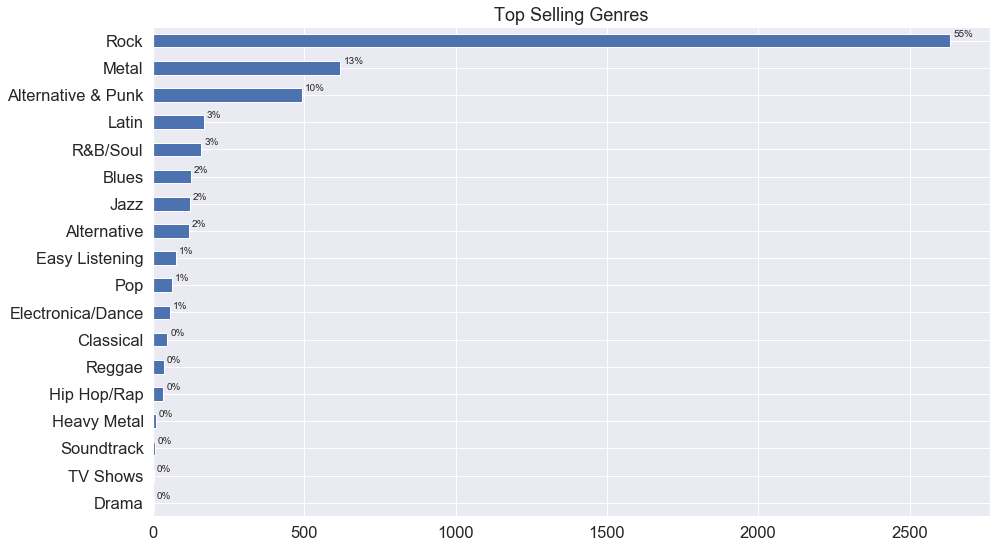

In [7]:
genre_reparition.set_index("genre",inplace=True,drop=True)

genre_reparition.tracks_purchased.plot.barh(y="genre",title="Top Selling Genres",figsize=(15,9)).invert_yaxis()

plt.ylabel('')

for i, label in enumerate(list(genre_reparition.index)):
    score = genre_reparition.loc[label, "tracks_purchased"]
    label = (genre_reparition.loc[label, "percentage_sold"] * 100).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show();


More the 50% of the total sales is due to a single genre : Rock. If Chinook should expand its catalogue with new artists or collections, Rock and its derivates would bring the best return on investment.

### What is the most popular music genre for each country ?

Saturated guitar music styles have taken over most of Chinook customers, but are there countries where people favor more delicate styles ? Spoiler : as the graph and data above might suggest, there are none. 

But here's how to be sure :

In [8]:
run_query("""
WITH t1 AS (
SELECT c.country, gr.name, COUNT(i.invoice_id) purchases  
FROM Invoice i
    JOIN customer c ON c.customer_id = i.customer_id
    JOIN invoice_line il ON il.invoice_id = i.invoice_id
    JOIN track t ON t.track_id = il.track_id
    JOIN genre gr ON gr.genre_id = t.genre_id
    
GROUP BY c.country, gr.name
ORDER BY c.country, purchases DESC
)

SELECT t1.*
FROM t1
JOIN (
    SELECT MAX(purchases) AS max_purchases, country, name
    FROM t1
    GROUP BY country
    )t2
ON t1.country = t2.country
WHERE t1.purchases = t2.max_purchases;    
""")

,country,name,purchases
0,Argentina,Alternative & Punk,17
1,Australia,Rock,34
2,Austria,Rock,40
3,Belgium,Rock,26
4,Brazil,Rock,205
5,Canada,Rock,333
6,Chile,Rock,61
7,Czech Republic,Rock,143
8,Denmark,Rock,24
9,Finland,Rock,46


### Best customer for each country


Customers will be divided into three categories according to the total amount of money they have spent :
- "small spender" : for everyone with less than 40$ spent on Chinook
- "regular" : for everyone between 40\$ and 100$
- "big spender" : for everyone above 100$

In [9]:
best_customers = run_query("""
WITH Spenders AS
(
SELECT c.country, 
    SUM(i.total) total_spent, 
    c.first_name || " " || c.last_name customer_name, 
    c.customer_id,
    COUNT(i.invoice_id) purchases,
    CASE
       WHEN sum(i.total) < 40 THEN 'small spender'
       WHEN sum(i.total) > 100 THEN 'big spender'
       ELSE 'regular'
       END 
       AS customer_category
FROM customer c
JOIN invoice i on i.customer_id = c.customer_id
GROUP BY c.customer_id
)

SELECT Spenders.*

FROM Spenders
JOIN(
    SELECT country, MAX(total_spent) max_total_spent, customer_name , customer_id
    FROM Spenders
    GROUP BY country
) Spenders2

ON Spenders.country = Spenders2.country
WHERE Spenders.total_spent = Spenders2.max_total_spent
ORDER BY country;
""")

best_customers

,country,total_spent,customer_name,customer_id,purchases,customer_category
0,Argentina,39.600,Diego Gutiérrez,56,5,small spender
1,Australia,81.180,Mark Taylor,55,10,regular
2,Austria,69.300,Astrid Gruber,7,9,regular
3,Belgium,60.390,Daan Peeters,8,7,regular
4,Brazil,108.900,Luís Gonçalves,1,13,big spender
5,Canada,99.990,François Tremblay,3,9,regular
6,Chile,97.020,Luis Rojas,57,13,regular
7,Czech Republic,144.540,František Wichterlová,5,18,big spender
8,Denmark,37.620,Kara Nielsen,9,10,small spender
9,Finland,79.200,Terhi Hämäläinen,44,11,regular


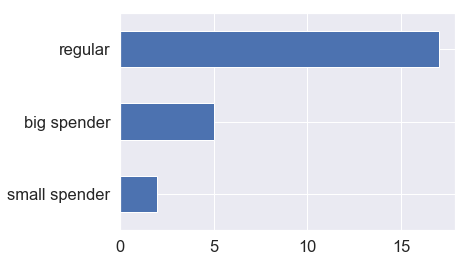

In [10]:
best_customers.customer_category.value_counts().plot.barh().invert_yaxis()

Here we can notice that most of the top buyers of each country fall into the "regular" category. 

### Employee Sales Performance

In [11]:
employee_sales_performance = run_query("""
WITH customer_support_rep_sales AS
    (
     SELECT
         i.customer_id,
         
         c.support_rep_id,
         SUM(i.total) total
     FROM invoice i
     INNER JOIN customer c ON i.customer_id = c.customer_id
     GROUP BY 1,2
    )

SELECT
    e.first_name || " " || e.last_name employee,
    e.hire_date,
    SUM(csrs.total) total_sales
FROM customer_support_rep_sales csrs
INNER JOIN employee e ON e.employee_id = csrs.support_rep_id
GROUP BY 1;
""")

employee_sales_performance

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.510
1,Margaret Park,2017-05-03 00:00:00,1584.000
2,Steve Johnson,2017-10-17 00:00:00,1393.920


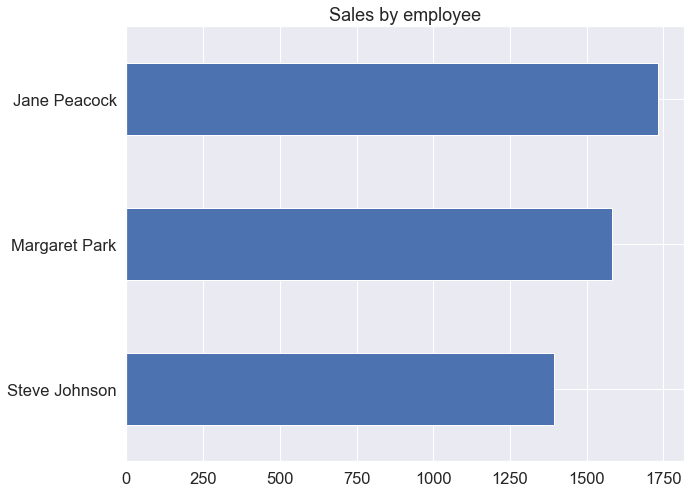

In [12]:
employee_sales_performance.set_index("employee", drop=True, inplace=True)
employee_sales_performance.sort_values("total_sales", inplace=True)
employee_sales_performance.plot.barh(legend=False,title='Sales by employee',figsize=(10,8))
    
plt.ylabel('')
plt.show();

Only three people work for Chinook. The more time they have spent since they hiring date, the more sales they have made. That explains explains the differences between them.

### Sales by Country

For each country we will retrieve the :

- total number of customers
- total value of sales
- average value of sales per customer
- average order value
- customer lifetime value



Since some countries have only one customer, they will fall into a category named "other" to make things a bit clearer.

In [13]:
sales_by_country = run_query("""
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );

""")
sales_by_country

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.490,7.943,80.038
1,Canada,8,535.590,7.047,66.949
2,Brazil,5,427.680,7.011,85.536
3,France,5,389.070,7.781,77.814
4,Germany,4,334.620,8.161,83.655
5,Czech Republic,2,273.240,9.108,136.620
6,United Kingdom,3,245.520,8.769,81.840
7,Portugal,2,185.130,6.384,92.565
8,India,2,183.150,8.721,91.575
9,Other,15,1094.940,7.449,72.996


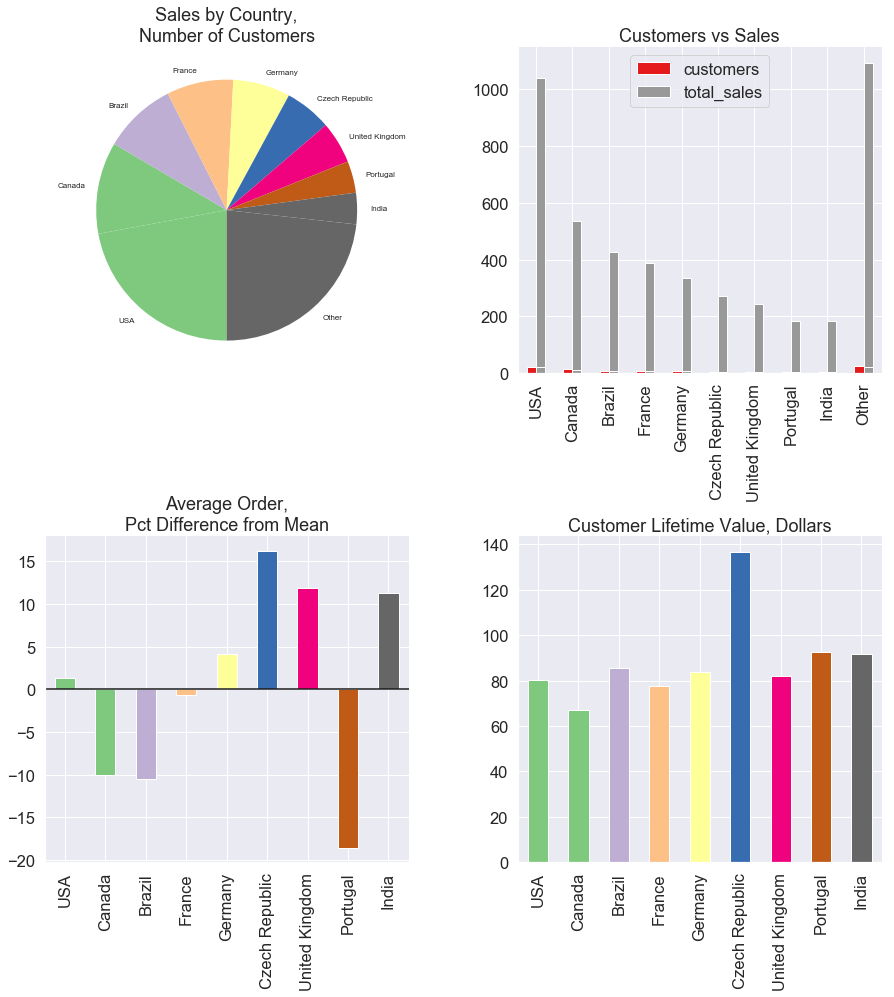

In [14]:
country_metrics = sales_by_country.copy()
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)

# top left
sales_breakdown = country_metrics["total_sales"].copy().rename("")
sales_breakdown.plot.pie(ax=ax1,startangle=-90,counterclock=False,title="Sales by Country,\nNumber of Customers", 
                         colormap=plt.cm.Accent, fontsize=8,wedgeprops={"linewidth":0})

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ""
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
    custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Customers vs Sales"
)
ax2.tick_params(top=False, right=False, left=False, bottom=False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.legend(["customers","total_sales"])

# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top=False, right=False, left=False, bottom=False)
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ""
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top=False, right=False, left=False, bottom=False)
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show();



### Would it be better to only buy the most popular song of an album instead of every track ?

Chinook buys whole albums from record companies that are then available to download entirely or piece by piece. Considering that fact, would it be better for Chinook to only buy the most popular song of each album instead of purchasing every track from an album ?

To anwser that question, we will need to find what percentage of purchases are due to individual tracks buying and how much come from whole album purchases.

In [15]:
albums_vs_tracks = run_query("""
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (SELECT COUNT(*) FROM invoice) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id) 

                  EXCEPT 
                  
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
""")

albums_vs_tracks

,album_purchase,number_of_invoices,percent
0,no,500,0.814
1,yes,114,0.186


Most people don't buy a whole album on Chinook. But almost 19% of them are still doing it, steering clear off that option would most likely harm Chinook's benefits. 